In [1]:
# data science libraries
import numpy as np
import pandas as pd
import gseapy as gp
import statsmodels.api as sm
import scipy
from scipy import stats
from scipy.stats import pearsonr

# machine learning libraries
from sklearn.cross_decomposition import PLSRegression, PLSCanonical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
import joblib
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import KFold

# data visualization libraries
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import Colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
from PIL import Image
from wordcloud import WordCloud

# general tools
import re 
import csv
from roman import toRoman, fromRoman
from tqdm import tqdm
from collections import defaultdict

In [2]:
print('The gseapy version is {}.'.format(gp.__version__))

The gseapy version is 1.1.1.


# Pre-processing steps 

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#get cell annotations
annot = pd.read_csv('cell-annotation.csv')
#get cell type categories
cells_cat = list(annot['cell.type'].unique())

with open('batch_list.txt') as f:
    batch_list = f.readlines()
#cleaning list    
batches = []
for b in batch_list:
    b = b.strip('/\n')
    batches.append(b)

In [ ]:
# ---------------------- Useful functions ----------------------

def drop_cols(cleaned_df,list_of_cols):
    constant_cols_count = 0
    nearly_constant_cols_count = 0
    cleaned_df = cleaned_df[list_of_cols]
    #now check if most common value of each col appears 90% of the time or more
    #if so, drop that column
    for cur_col in list_of_cols:
        # print(cur_col)
        if cleaned_df[cur_col].nunique() == 1: #check number of unique vals, if its all 1 then drop the column
            cleaned_df = cleaned_df.drop(cur_col, axis=1)
            # print('dropped bc 1 val:', cur_col)
            # print('constant: ', cur_col)
            constant_cols_count += 1
        elif cleaned_df[cur_col].nunique() > 1: #check number of unique vals, if its >1 then drop the column if >=90% of values are most common value
            #print(‘checking:’, cur_col)
            most_common_val_count = cleaned_df[cur_col].sort_values(ascending=False).value_counts().iloc[0] #number of times the most common value occurs
            total_val_count = cleaned_df[cur_col].sort_values(ascending=False).value_counts().sum() #total number of values in column
            percent_most_common_val = most_common_val_count/total_val_count #percentage of entries the most common entry accounts for
            if percent_most_common_val >= 0.90: #drop if >=99%
                print('dropped bc >=90%:', cur_col)
                cleaned_df = cleaned_df.drop(cur_col, axis=1)
                # print('90 percent constant: ', cur_col)
                nearly_constant_cols_count += 1
    return cleaned_df

def overlap(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def deconf(dff,conf):
        df = dff.copy()
        for col in df.columns:
                conf_with_bias = sm.add_constant(conf)
                model = sm.OLS(df[col],conf_with_bias).fit()
                df[col] = model.resid
        return df

def zscore(dff,col):
        df = dff.copy()
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[[col]])
        return df

#function for missing data imputation
def my_impute(dff, col):
    new_df = dff.copy()
    arr = pd.to_numeric(new_df[col])
    arr = np.array(arr)
    b_nan = np.isnan(arr)
    b_negative = arr < 0
    b_bad = b_nan | b_negative
    arr[b_bad] = np.random.choice(arr[~b_bad], np.sum(b_bad))
    new_df[col] = arr
    return new_df

In [6]:
# Initialize a set to store all unique genes
unique_genes = set()

# Load genes from each cell type and add to the set
for cell_type in tqdm(cells_cat, desc="Loading genes by cell type"):  
    genes_list = np.load(f'./ROSMAP_seurat_QC/by_cell_type/{cell_type}_genes_names.npy', allow_pickle=True)
    unique_genes.update(genes_list)

# Separate mitochondrial and nuclear genes
MT_genes = sorted([gene for gene in unique_genes if gene.startswith('MT-')])
nuc_genes = sorted(unique_genes - set(MT_genes))

# Compute overlapping genes across all cell types
overlap_genes = unique_genes.copy()
for cell_type in tqdm(cells_cat, desc="Computing overlap"):
    genes_list = set(np.load(f'./ROSMAP_seurat_QC/by_cell_type/{cell_type}_genes_names.npy', allow_pickle=True))
    overlap_genes = overlap(overlap_genes, genes_list)

overlap_genes = sorted(overlap_genes)

Loading genes by cell type:   0%|          | 0/16 [00:00<?, ?it/s]

Computing overlap: 100%|██████████| 16/16 [00:00<00:00, 654.48it/s]


In [7]:
MT_genes = [gene for gene in overlap_genes if gene.startswith('MT-')]
nuc_genes = [gene for gene in overlap_genes if not gene.startswith('MT-')]

print("Mitochondrial genes:")
for gene in MT_genes:
    print(gene)

Mitochondrial genes:
MT-ATP6
MT-ATP8
MT-CO1
MT-CO2
MT-CO3
MT-CYB
MT-ND1
MT-ND2
MT-ND3
MT-ND4
MT-ND4L
MT-ND5
MT-ND6


In [8]:
# ---------------------- Load clinical data ----------------------
clinic = pd.read_csv('ROSMAP_clinical_combined_cleaned.csv', index_col=0)
print(f'Clinical data shape: {clinic.shape}')

# Remove columns not needed for analysis
clinic_cols = [col for col in clinic.columns if col not in ['Study', 'individualID_y']]

# ---------------------- Separate AD and healthy individuals ----------------------
# AD patients
clin_ad = clinic.loc[clinic.dcfdx_ad == 1]
ad_clin_df = drop_cols(clin_ad, clinic_cols)

# Columns to keep for AD analysis / classification
ad_cols = list(ad_clin_df.columns) + [
    'dcfdx_ad', 'dcfdx_mci', 'dcfdx_other', 'e4_status',
    'cogdx_ad', 'cogdx_mci', 'cogdx_other'
]

# Healthy individuals
clin_healthy = clinic.loc[clinic.dcfdx_ad == 0]
healthy_clin_df = drop_cols(clin_healthy, clinic_cols)

# Columns to keep for healthy analysis / classification
hc_cols = list(healthy_clin_df.columns) + [
    'dcfdx_ad', 'dcfdx_other', 'e4_status',
    'cogdx_ad', 'cogdx_mci', 'cogdx_other'
]

# ---------------------- Identify overlapping columns ----------------------
all_clin_cols = overlap(hc_cols, ad_cols)  # Only keep columns present in both groups
all_clin_cols.append('cogdx')  # Add final column for analysis

# Remove duplicates while preserving order
seen = set()
no_dup = []
for col in all_clin_cols:
    if col not in seen:
        no_dup.append(col)
        seen.add(col)
    else:
        print(f'Found duplicate: {col}')

all_clin_cols = no_dup
print(f'Final clinical columns ({len(all_clin_cols)}): {all_clin_cols}')


Clinical data shape: (424, 64)
dropped bc >=90%: APOE_22.0
dropped bc >=90%: APOE_24.0
dropped bc >=90%: APOE_44.0
dropped bc >=90%: cogdx_ad
dropped bc >=90%: cogdx_other
dropped bc >=90%: APOE_22.0
dropped bc >=90%: APOE_24.0
dropped bc >=90%: APOE_44.0
dropped bc >=90%: cogdx_ad
dropped bc >=90%: cogdx_other
dropped bc >=90%: dcfdx_other
Found duplicate: e4_status
Found duplicate: cogdx_mci
Found duplicate: cogdx
Final clinical columns (57): ['individualID', 'projid', 'msex', 'educ', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', 'APOE_23.0', 'APOE_33.0', 'APOE_34.0', 'cogdx_mci', 'dcfdx_mci', 'cerad_binary', 'e4_status', 'study', 'scaled_to', 'neuroticism_12', 'apoe_genotype', 'age_bl', 'menoage', 'ldai_bl', 'smoking_bl', 'cancer_bl', 'gpath', 'amyloid', 'dlbdx', 'lb_7reg', 'nft', 'tangles', 'tdp_st4', 'arteriol_scler', 'caa_4gp', 'cvda_4gp2', 'ci_num2_gct', 'ci_num2_mct', 'ci_num2_tct

In [9]:
pls_cells = [
 'Excitatory Neurons',
 'Inhibitory Neurons',
 'Oligodendrocytes',
 'Astrocyte',
 'OPCs',
 'Microglia',
 'Endothelial',
 'Pericytes',
 'SMC',
 'Fibroblast',
 'all_immune_cells',
 'Macrophages',
 ]

In [10]:
#combining all immune cell together excluding macrophages
immune_cells = ['Monocytes','NK Cells','Neutrophils','CD8+ T Cells']

In [11]:
cells_order = [
 'Excitatory Neurons',
 'Oligodendrocytes',
 'Inhibitory Neurons',
 'Astrocyte',
 'Microglia',
 'OPCs',
 'Endothelial',
 'Fibroblast',
 'Pericytes',
 'Macrophages',
 'SMC',
 'all_immune_cells',
 ]

# PLS-DA

## Running PLS

In [12]:
def load_cell_type_data(cell_type, date, clinic, all_clin_cols, nuc_genes, immune_cells=None):
    """
    Load and merge gene expression, metadata, and clinical data for a cell type.

    Args:
        cell_type (str): The cell type to load. Can be 'all_immune_cells' to merge multiple immune types.
        date (str): Path prefix for saving output.
        clinic (pd.DataFrame): Clinical dataframe.
        all_clin_cols (list): List of clinical columns to include.
        nuc_genes (list): List of nuclear genes.
        immune_cells (list, optional): List of immune cell types if cell_type is 'all_immune_cells'.

    Returns:
        cells_df (pd.DataFrame): Merged dataframe for this cell type.
    """
    if cell_type == 'all_immune_cells':
        all_cells = []
        for immune_cell_type in immune_cells:
            print(f'Loading {immune_cell_type} data...')
            meta_data = pd.read_csv(f'./ROSMAP_seurat_QC_5440/by_cell_type/with_nan/{immune_cell_type}_meta_data.csv', index_col=0)
            barcodes = meta_data['barcode'].tolist()
            meta_data.set_index('barcode', inplace=True)

            genes_arr = np.load(f'./ROSMAP_seurat_QC_5440/by_cell_type/with_nan/{immune_cell_type}_genes_arr.npy')
            genes_list = np.load(f'./ROSMAP_seurat_QC_5440/by_cell_type/with_nan/{immune_cell_type}_genes_names.npy', allow_pickle=True)

            cells_df = pd.DataFrame(genes_arr, index=barcodes, columns=genes_list)
            cells_df = cells_df.merge(meta_data, left_index=True, right_index=True).merge(clinic[all_clin_cols], on='individualID', how='inner')
            all_cells.append(cells_df)
            print(f'{immune_cell_type} shape: {cells_df.shape}')

        cells_df = pd.concat(all_cells, axis=0).fillna(0)
        all_clin_cols.append('individualID')

    else:
        print(f'Loading {cell_type} data...')
        meta_data = pd.read_csv(f'./ROSMAP_seurat_QC_5440/by_cell_type/with_nan/{cell_type}_meta_data.csv', index_col=0)
        barcodes = meta_data['barcode'].tolist()
        meta_data.set_index('barcode', inplace=True)

        genes_arr = np.load(f'./ROSMAP_seurat_QC_5440/by_cell_type/with_nan/{cell_type}_genes_arr.npy', allow_pickle=True)
        genes_list = np.load(f'./ROSMAP_seurat_QC_5440/by_cell_type/with_nan/{cell_type}_genes_names.npy', allow_pickle=True)

        cells_df = pd.DataFrame(genes_arr, index=barcodes, columns=genes_list)
        cells_df = cells_df.merge(meta_data, left_index=True, right_index=True).merge(clinic[all_clin_cols], on='individualID', how='inner')
        all_clin_cols.append('individualID')

    return cells_df

In [ ]:
def load_cell_type_data(cell_type, date, clinic, all_clin_cols, nuc_genes, immune_cells=None):
    """
    Load and merge gene expression, metadata, and clinical data for a cell type.

    Args:
        cell_type (str): The cell type to load. Can be 'all_immune_cells' to merge multiple immune types.
        date (str): Path prefix for saving output.
        clinic (pd.DataFrame): Clinical dataframe.
        all_clin_cols (list): List of clinical columns to include.
        nuc_genes (list): List of nuclear genes.
        immune_cells (list, optional): List of immune cell types if cell_type is 'all_immune_cells'.

    Returns:
        cells_df (pd.DataFrame): Merged dataframe for this cell type.
    """
    if cell_type == 'all_immune_cells':
        all_cells = []
        for immune_cell_type in immune_cells:
            print(f'Loading {immune_cell_type} data...')
            meta_data = pd.read_csv(f'./ROSMAP_seurat_QC_5440/by_cell_type/with_nan/{immune_cell_type}_meta_data.csv', index_col=0)
            barcodes = meta_data['barcode'].tolist()
            meta_data.set_index('barcode', inplace=True)

            genes_arr = np.load(f'./ROSMAP_seurat_QC_5440/by_cell_type/with_nan/{immune_cell_type}_genes_arr.npy')
            genes_list = np.load(f'./ROSMAP_seurat_QC_5440/by_cell_type/with_nan/{immune_cell_type}_genes_names.npy', allow_pickle=True)

            cells_df = pd.DataFrame(genes_arr, index=barcodes, columns=genes_list)
            cells_df = cells_df.merge(meta_data, left_index=True, right_index=True).merge(clinic[all_clin_cols], on='individualID', how='inner')
            all_cells.append(cells_df)
            print(f'{immune_cell_type} shape: {cells_df.shape}')

        cells_df = pd.concat(all_cells, axis=0).fillna(0)
        all_clin_cols.append('individualID')

    else:
        print(f'Loading {cell_type} data...')
        meta_data = pd.read_csv(f'./ROSMAP_seurat_QC_5440/by_cell_type/with_nan/{cell_type}_meta_data.csv', index_col=0)
        barcodes = meta_data['barcode'].tolist()
        meta_data.set_index('barcode', inplace=True)

        genes_arr = np.load(f'./ROSMAP_seurat_QC_5440/by_cell_type/with_nan/{cell_type}_genes_arr.npy', allow_pickle=True)
        genes_list = np.load(f'./ROSMAP_seurat_QC_5440/by_cell_type/with_nan/{cell_type}_genes_names.npy', allow_pickle=True)

        cells_df = pd.DataFrame(genes_arr, index=barcodes, columns=genes_list)
        cells_df = cells_df.merge(meta_data, left_index=True, right_index=True).merge(clinic[all_clin_cols], on='individualID', how='inner')
        all_clin_cols.append('individualID')

    return cells_df

In [13]:
def preprocess_and_fit_pls(cells_df, cell_type, date, nuc_genes):
    """
    Preprocess gene expression, remove MCI cells, deconfound with PMI, and fit PLS model.

    Args:
        cells_df (pd.DataFrame): Merged dataframe for cell type.
        cell_type (str): Cell type name for saving outputs.
        date (str): Path prefix for saving outputs.
        nuc_genes (list): Nuclear genes to select from cells_df.
    """
    # Extract nuclear genes
    genes_exp = cells_df[nuc_genes]

    # Remove MCI or other non-AD cells
    mci_bool = (cells_df.cogdx_mci == 1) | (cells_df.cogdx_other == 1)
    print(f'Removing {mci_bool.sum()} cells with MCI/other')

    AD_cog = cells_df.loc[~mci_bool, ['cogdx_ad']].replace(0, -1).to_numpy()
    genes_exp = genes_exp.loc[~mci_bool].to_numpy()

    # Save clinical info for remaining cells
    cells_df.loc[~mci_bool].to_csv(f'{date}/AD_PLS/{cell_type}_clin_no_MT.csv')

    # Deconfound with PMI and z-score
    pmi = cells_df.loc[~mci_bool, ['pmi']].to_numpy()
    genes_exp = StandardScaler().fit_transform(deconf(genes_exp.filna(0), pmi))
    AD_cog = StandardScaler().fit_transform(deconf(AD_cog, pmi))

    # Fit PLS
    pls = PLSRegression(n_components=20)
    print('Computing PLS...')
    pls.fit(genes_exp, AD_cog)
    joblib.dump(pls, f'{date}/AD_PLS/pls_{cell_type}_no_MT_20_cog_z.gz')
    print('Saved!\n')


In [14]:
# ---------------------- Main loop ----------------------
# for cell_type in pls_cells:
#     cells_df = load_cell_type_data(cell_type, date, clinic, all_clin_cols, nuc_genes, immune_cells)
#     preprocess_and_fit_pls(cells_df, cell_type, date, nuc_genes)

## Perumations analysis 

In [15]:
date = '08.13.25'

In [16]:
def deconf_arr(arr, conf):
    """
    Remove the effect of confounding variables from a data matrix using linear regression.

    Args:
        arr (array-like): 2D array of shape (n_samples, n_features) containing the data to deconfound.
        conf (array-like): 2D array of confounding variables of shape (n_samples, n_confounds).

    Returns:
        np.ndarray: Residualized data with the effects of confounders removed (same shape as arr).
    """
    
    # Ensure input data is a NumPy array
    arr = np.asarray(arr)
    
    # Add an intercept (bias) column to the confound matrix for the regression
    conf_with_bias = sm.add_constant(conf)
    
    # Initialize an empty array to store residuals
    resid = np.empty_like(arr, dtype=float)
    
    # Loop over each feature (column) in arr
    for i in range(arr.shape[1]):
        # Fit ordinary least squares regression of feature i on confounders
        model = sm.OLS(arr[:, i], conf_with_bias).fit()
        
        # Store residuals (i.e., data after removing confounder effects)
        resid[:, i] = model.resid
    
    # Return residualized data
    return resid

def permutation_test_pls(cells_df, cell_type, date, nuc_genes):
    """
    Preprocess gene expression, remove MCI cells, deconfound with PMI, and fit PLS model.

    Args:
        cells_df (pd.DataFrame): Merged dataframe for cell type.
        cell_type (str): Cell type name for saving outputs.
        date (str): Path prefix for saving outputs.
        nuc_genes (list): Nuclear genes to select from cells_df.
    """
    # Extract nuclear genes
    genes_exp = cells_df[nuc_genes]

    # Remove MCI or other non-AD cells
    mci_bool = (cells_df.cogdx_mci == 1) | (cells_df.cogdx_other == 1)
    print(f'Removing {mci_bool.sum()} cells with MCI/other')

    AD_cog = cells_df.loc[~mci_bool, ['cogdx_ad']].replace(0, -1).to_numpy()
    genes_exp = genes_exp.loc[~mci_bool].to_numpy()

    # Save clinical info for remaining cells
    cells_df.loc[~mci_bool].to_csv(f'{date}/AD_PLS/{cell_type}_clin_no_MT.csv')

    # Deconfound with PMI and z-score
    pmi = cells_df.loc[~mci_bool, ['pmi']].to_numpy()
    genes_exp = StandardScaler().fit_transform(deconf(genes_exp.filna(0), pmi))
    AD_cog = StandardScaler().fit_transform(deconf(AD_cog, pmi))

    np.save(f'{date}/AD_PLS/permutations/zscore/genes_exp_arr_{cell_type}.npy', genes_exp)
    np.save(f'{date}/AD_PLS/permutations/zscore/AD_{cell_type}.npy', AD_cog)

    def fit_and_save(i):
        pls = PLSRegression(n_components=20, copy=False)
        np.random.seed(i)
        x = np.load(f'{date}/AD_PLS/permutations/zscore/genes_exp_arr_{cell_type}.npy')
        AD_cog = np.load(f'{date}/AD_PLS/permutations/zscore/AD_{cell_type}.npy')
        np.random.shuffle(AD_cog)
        # AD_cog = shuffle(AD_cog, random_state=i)
        pls.fit(x, AD_cog)
        joblib.dump(pls,f'{date}/AD_PLS/permutations/zscore/{cell_type}_pls_{i}.gz')

    # Define your data and model parameters
    num_iterations = 100
    if cell_type == 'Excitatory Neurons':
        num_cores = 10
        b = 0
    else:
        num_cores = 20
        b = 0
         
    Parallel(n_jobs=num_cores,temp_folder='/home/bic/chloes/pool8_z0/tmp',pre_dispatch=num_cores,verbose=10)(
        delayed(fit_and_save)(i) for i in tqdm(range(b,num_iterations))
    )

In [17]:
# ---------------------- Main loop ----------------------
# for cell_type in pls_cells:
#     cells_df = load_cell_type_data(cell_type, date, clinic, all_clin_cols, nuc_genes, immune_cells)
#     permutation_test_pls(cells_df, cell_type, date, nuc_genes)

### Plotting permutations results

In [18]:
new_cols = ['comp_' + str(col) for col in range(1, 21)]

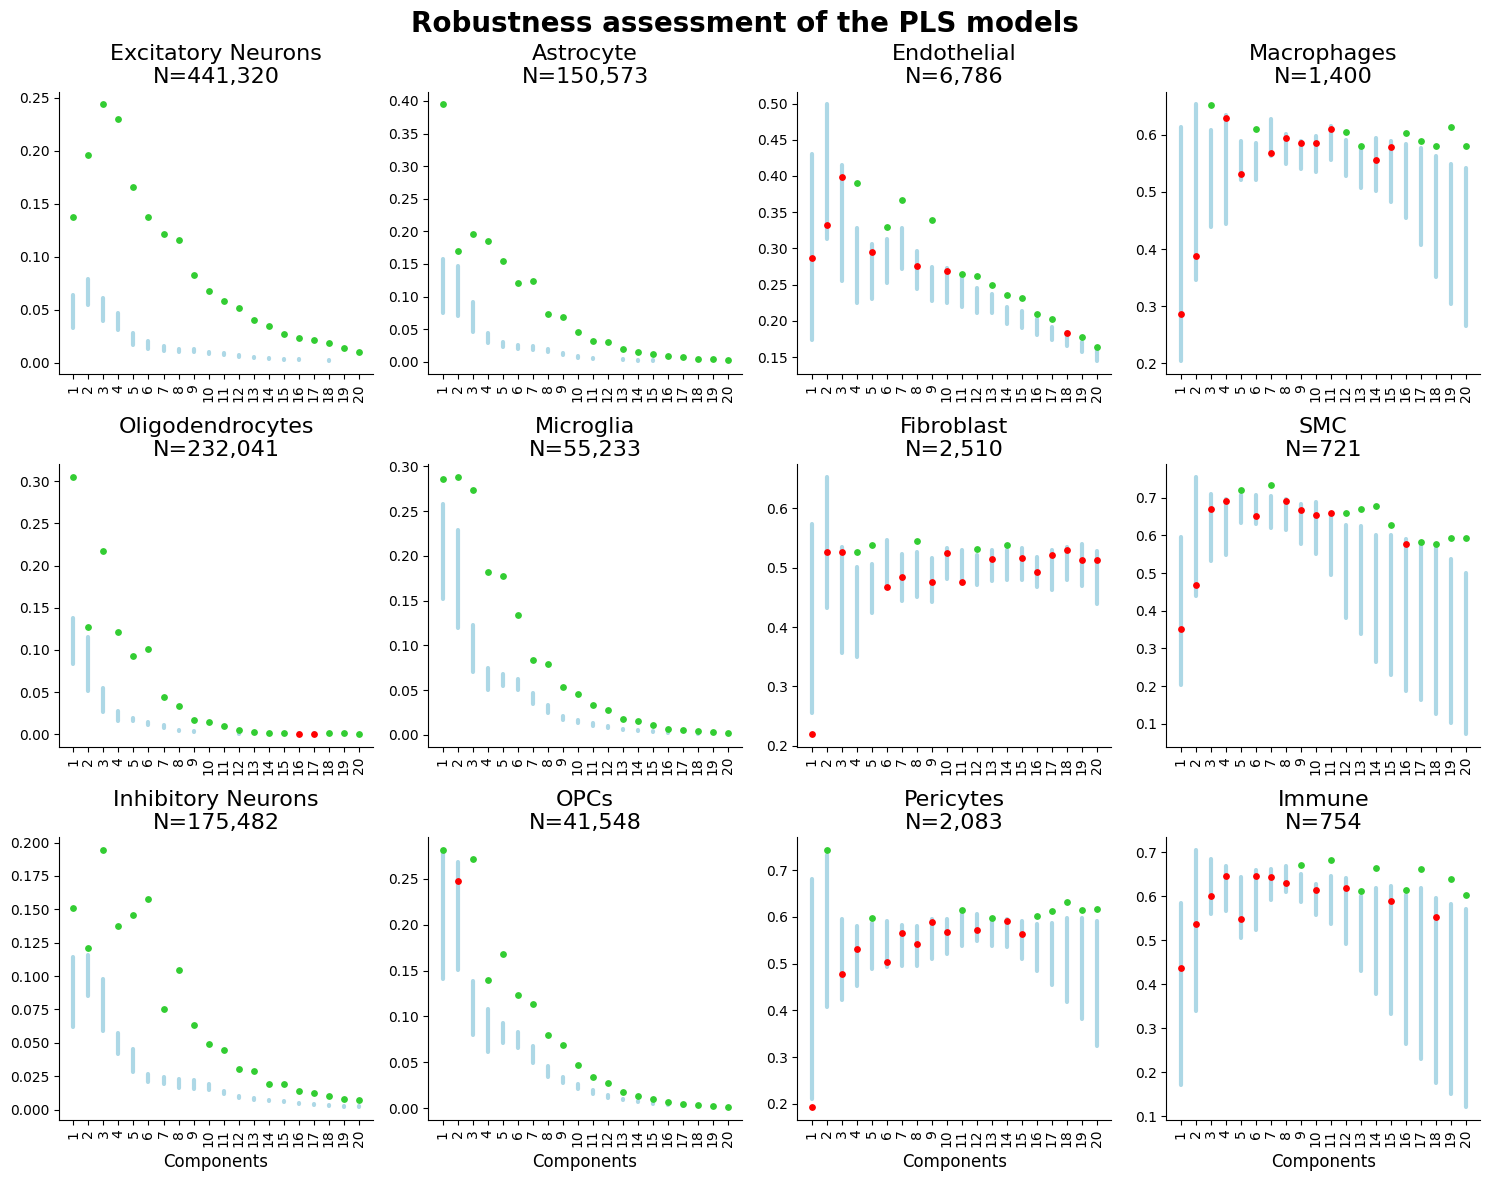

In [19]:
date = '08.13.25'

i = 0
j = 0
fig, axs = plt.subplots(3, 4,figsize=(15,12))
for cell_type in cells_order:

    dist = np.load(f'{date}/AD_PLS/permutations/zscore/{cell_type}_perm_dist.npy')
    low_b = list(np.percentile(dist[:,0:100],10,axis=1))
    up_b = list(np.percentile(dist[:,0:100],90,axis=1))
    median = list(np.percentile(dist[:,0:100],50,axis=1))
    
    xt = range(len(new_cols))
    pls = joblib.load(f'{date}/AD_PLS/pls_{cell_type}_no_MT_20_cog_z.gz')
    actual_Rs = np.array([pearsonr(X_coef, Y_coef)[0] for X_coef, Y_coef in zip(pls.x_scores_.T, pls.y_scores_.T)])
    plot_df = pd.DataFrame(index=new_cols)
    plot_df['low_b'] = low_b
    plot_df['up_b'] = up_b
    plot_df['median'] = median
    plot_df['pearsonr'] = actual_Rs

    axs[i,j].plot((xt,xt),(plot_df.low_b,plot_df.up_b), lw=3, solid_capstyle='round',color='lightblue',zorder=2)

    # Compare element-wise
    for k, actual_R in enumerate(actual_Rs):
        if actual_R > plot_df.up_b[k]:
            axs[i, j].scatter(x=k, y=actual_R, s=15, color='limegreen', zorder=3)
        else:
            axs[i, j].scatter(x=k, y=actual_R, s=15, color='red', zorder=3)

    # axs[i,j].scatter(x=xt,y=plot_df['median'], s=10, color='lightblue',zorder=2)
    # axs[i,j].scatter(y=plot_df['pearsonr'],x=xt,s=15,color='red',zorder=3)
    axs[i,j].set_xticks(ticks=xt,rotation=90,labels=range(1,21))
    if cell_type == 'all_immune_cells':
        cell_type = 'Immune'
    axs[i,j].set_title(f'{cell_type}\nN={len(pls.y_scores_):,}', fontsize=16)

    axs[i,j].grid(False)
    axs[i,j].spines[['right', 'top']].set_visible(False)
    if i == 2:
        axs[i,j].set_xlabel('Components', fontsize=12)

    if (i == 2)&(j == 0):
        j = 1
        i = 0
    elif (i == 2)&(j == 1):
        j = 2
        i = 0
    elif (i == 2)&(j == 2):
        j = 3
        i = 0
    else:
        i+=1

fig.suptitle('Robustness assessment of the PLS models',fontweight="bold",fontsize=20)
fig.tight_layout()
plt.savefig(f'{date}/updated_plots/perm_no_MT_100.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close('all')

## Gene Set Enrichment Analysis (GSEA)

### GSEA for Mitochondria with MitoCarta

In [20]:
date = '08.13.25'

In [21]:
# Read data from the GMX file
with open('MitoPathways3.0.gmx') as gmx:
    lines = gmx.readlines()

# Write the data to a CSV file
output_filename = 'MitoPathways3.0.csv'
with open(output_filename, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    for line in lines:
        writer.writerow([line.strip()])
print(f"Data saved to {output_filename}")   

Data saved to MitoPathways3.0.csv


In [22]:
MitoCarta_df = pd.read_csv('MitoPathways3.0.csv',sep='\t').T

In [23]:
def mito_gsea2(pathh, pls, gene_list, comp, pval, save=False):
    """
    Perform gene set enrichment analysis (GSEA) on a single PLS component
    using mitochondrial pathways.

    Args:
        pathh (str): Directory path for saving results if `save=True`.
        pls: Fitted PLSRegression object with attribute x_loadings_.
        gene_list (list): List of genes corresponding to the PLS loadings.
        comp (int): Index of the PLS component to analyze.
        pval (float): FDR threshold to consider pathways as significant.
        save (bool, optional): Whether to save results to a text file.

    Returns:
        pd.DataFrame: DataFrame of significant GSEA pathways for the given component.
    """

    # Extract PLS loadings for the specified component
    loading = pls.x_loadings_[:, comp]

    # Perform preranked GSEA using gene weights (PLS loadings)
    nz_res = gp.prerank(
        rnk=pd.DataFrame({'genes': gene_list, 'PLS_weights': loading}),
        gene_sets='MitoPathways3.0.gmt',  # Mitochondrial pathway gene sets
        min_size=5,                        # Minimum gene set size
        max_size=len(gene_list),           # Maximum gene set size
        outdir=None,                       # Do not save default GSEA output
        permutation_num=1000,              # Number of permutations for significance
        seed=42,                           # Reproducibility
        verbose=False
    )

    # Extract results as DataFrame
    nz_gsea_df = nz_res.res2d

    # Order pathways by enrichment score (ES)
    nz_gsea_df = nz_gsea_df.sort_values(by='ES')

    # Filter pathways that pass FDR threshold
    nz_gsea_df_sig = nz_gsea_df[nz_gsea_df["FDR q-val"] < pval].reset_index(drop=True)

    # Optional: append results to a text file for visual inspection
    if save:
        with open(f'{pathh}/gsea_{cell_type}_{pval}.txt', 'a') as f:
            f.write(f'PLS-C {comp+1} \n')
            f.write(f'Number of significantly enriched pathways: {nz_gsea_df_sig.Term.values.shape[0]} \n')
            f.write('Pathways \n')
            f.write(f'{nz_gsea_df_sig.Term.values} \n')
            f.write('\n')

    # Return significant pathways
    return nz_gsea_df_sig


In [24]:
def filter_mitocarta_hits(nz_gsea_df_sig):
    terms = []
    nes = []
    hits_df = pd.DataFrame()
    # Loop through all significant GSEA hits
    for hits in range(0,len(nz_gsea_df_sig)):
        # Replace '.' with ' : ' and '_' with ' ' for readability
        go_1 = nz_gsea_df_sig.Term[hits].replace('.',' : ').replace('_',' ')
        terms.append(go_1)
        nes.append(nz_gsea_df_sig.NES[hits])

    # Filter nested or subcategory terms
    filtered_terms = []
    filtered_nes = []
    for i in range(0,len(terms)):
        if i == 0:
            filtered_terms.append(terms[0])
            filtered_nes.append(nes[0])
        elif terms[i] in terms[i-1]:
            # Skip subcategories that are part of previous terms
            continue
        else:
            filtered_terms.append(terms[i])
            filtered_nes.append(nes[i])

    # Returned filtered dataset
    hits_df['Term'] = filtered_terms
    hits_df['NES'] = filtered_nes
    return hits_df

def roman_to_arabic(text):
    # Regex pattern to match Roman numerals
    pattern = r'\b[IVXLCDM]+\b'
    
    def replace(match):
        # Convert Roman numerals to Arabic numerals
        return str(fromRoman(match.group(0)))
    
    # Replace Roman numerals with Arabic numerals in the text
    return re.sub(pattern, replace, text)

def pruning(text):
    # Step 1: Replace 'Complex {k}' with 'Complex_{k}'
    pattern_step1 = r'Complex\s+(\d+)'
    text_step1 = re.sub(pattern_step1, r'Complex_\1', text)

    # Step 2: Replace '{k} subunits' with '{k}_subunits'
    pattern_step2 = r'(\d+)\s+subunits'
    text_step2 = re.sub(pattern_step2, r'\1_subunits', text_step1)

    return text_step2

def back_to_roman(vocabulary):
    reversed_vocabulary = []
    for items in vocabulary:
        subitems = []
        for word in items.split(' '):
            # If the word consists of digits or contains '_' and digits
            if re.match(r'\d+', word) or re.match(r'.*_\d+', word):
                parts = word.split('_')
                # Convert each part of the word containing digits to Roman numerals
                roman_parts = [toRoman(int(part)) if part.isdigit() else part for part in parts]
                subitems.append('_'.join(roman_parts))
            else:
                subitems.append(word)
        reversed_vocabulary.append(' '.join(subitems))
    return reversed_vocabulary

In [25]:
# Performs GSEA for each PLS component per cell type using MitoCarta pathways
# Save results into csv files (one per cell type)
mito_hits_cell_df = pd.DataFrame()
for cell_type in cells_order[0:6]:
    # print(cell_type)
    pls = joblib.load(f'{date}/AD_PLS/pls_{cell_type}_no_MT_20_cog_z.gz')
    # genes = nuc_genes
    genes = np.load(f'{date}/AD_PLS/{cell_type}_genes_list.npy')
    new_path = f'{date}/AD_PLS/MitoCarta'

    pval = 0.05

    cell_type_paths_df = pd.DataFrame()
    for comp in tqdm(range(0,20)):
        hits_df = pd.DataFrame()
        nz_gsea_df_sig = mito_gsea2(new_path, pls, genes, comp, pval, save=False)
        nz_gsea_df_sig = nz_gsea_df_sig.sort_values(by='Term',ascending=False).reset_index(drop=True)
        nz_gsea_df_sig.to_csv(f'{new_path}/hits_{cell_type}_comp_{comp+1}_pval_{pval}.csv')
        nz_gsea_df_sig = pd.read_csv(f'{new_path}/hits_{cell_type}_comp_{comp+1}_pval_{pval}.csv', index_col=0)
        hits = filter_mitocarta_hits(nz_gsea_df_sig)
        hits_df[f'comp_{comp+1}'] = hits.Term
        cell_type_paths_df = pd.concat([cell_type_paths_df,hits_df.T])
        cell_type_paths_df.to_csv(f'{new_path}/{cell_type}_hits_no_MT_20_pval_{pval}.csv')


100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


### GSEA with Gene Ontology 2023

In [26]:
def gsea2(pathh, pls, gene_list, comp, pval, save=False):
    """
    Perform Gene Set Enrichment Analysis (GSEA) on a single PLS component
    using GO Biological Process pathways.

    Args:
        pathh (str): Directory path for saving results if save=True.
        pls: Fitted PLSRegression object with attribute x_loadings_.
        gene_list (list): List of genes corresponding to the PLS loadings.
        comp (int): Index of the PLS component to analyze.
        pval (float): FDR threshold for significant pathways.
        save (bool, optional): Whether to save results to a text file.

    Returns:
        pd.DataFrame: DataFrame of significant GSEA pathways for the given component.
    """

    # Extract PLS loadings for the specified component
    loading = pls.x_loadings_[:, comp]

    # Perform preranked GSEA using gene weights (PLS loadings)
    nz_res = gp.prerank(
        rnk=pd.DataFrame({'genes': gene_list, 'PLS_weights': loading}),
        gene_sets='GO_Biological_Process_2023',  # Use GO BP 2023 gene sets
        min_size=5,                               # Minimum gene set size
        max_size=len(gene_list),                  # Maximum gene set size
        outdir=None,                              # Do not save default GSEA output
        permutation_num=1000,                     # Number of permutations for significance
        seed=42,                                  # Reproducibility
        verbose=False
    )

    # Extract results as a DataFrame
    nz_gsea_df = nz_res.res2d

    # Order pathways by enrichment score (ES)
    nz_gsea_df = nz_gsea_df.sort_values(by='ES')

    # Filter pathways that pass the FDR threshold
    nz_gsea_df_sig = nz_gsea_df[nz_gsea_df["FDR q-val"] < pval].reset_index(drop=True)

    # Optionally append results to a text file
    if save:
        with open(f'{pathh}/gsea_{cell_type}_{pval}.txt', 'a') as f:
            f.write(f'PLS-C {comp+1} \n')
            f.write(f'Number of significantly enriched pathways: {nz_gsea_df_sig.Term.values.shape[0]} \n')
            f.write('Pathways \n')
            f.write(f'{nz_gsea_df_sig.Term.values} \n')
            f.write('\n')

    # Return significant pathways
    return nz_gsea_df_sig

def summarize_paths(nz_gsea_df_sig, comp):
    """
    Summarize significant GSEA pathways for a given PLS component by grouping related terms.

    Args:
        nz_gsea_df_sig (pd.DataFrame): Significant pathways from GSEA with a 'Term' column.
        comp (int): Index of the PLS component (used for naming the output column).

    Returns:
        pd.DataFrame: A single-row DataFrame with grouped pathway terms for the component.
    """

    df = pd.DataFrame()  # Initialize empty DataFrame for output
    paths = []           # List to store grouped pathways

    # Loop over all significant GSEA hits
    for hits in range(len(nz_gsea_df_sig)):
        grp = []  # Temporary list to store a group of related pathways

        # Extract the last word of the GO term (used for initial grouping)
        go_1 = nz_gsea_df_sig.Term[hits].split(' ')[-1]

        # Skip if this term is already included in previous groups
        if go_1 in " ".join(str(element) for element in paths):
            continue

        # Add the current term to the group
        grp.append(nz_gsea_df_sig.Term[hits])

        # Compare with subsequent terms to find similar/related pathways
        for counter in range(1, len(nz_gsea_df_sig) - hits):
            go_2 = nz_gsea_df_sig.Term[hits + counter].split(' ')[-1]

            # Skip if this term is already included in previous groups
            if go_2 in " ".join(str(element) for element in paths):
                continue

            # Group terms with overlapping names (ignoring last 2 characters)
            elif go_1[:-2] == go_2[:-2]:
                grp.append(nz_gsea_df_sig.Term[hits + counter])

        # Add the grouped pathways to the main list
        paths.append(grp)

    # Clean and format grouped pathways into strings
    paths_list = []
    for path in paths:
        str_path = "; ".join(str(element) for element in path)  # Join group with '; '
        str_path = re.sub(r'\d+', '', str_path)                # Remove digits
        str_path = re.sub('[()]', '', str_path)                # Remove parentheses
        str_path = re.sub(':', '', str_path)                   # Remove colons
        paths_list.append(str_path)

    # Store the result in a DataFrame with component-specific column name
    df[f'comp_{comp+1}'] = paths_list
    df = df.T  # Transpose so that component is the row

    return df


In [27]:
print(date)

08.13.25


In [28]:
# This block performs GSEA for each cell type and PLS component using GO Biological Process 2023 pathways
# NOTE: It can take ~30 minutes to run for all cell types and components.

# new_path = f'{date}/AD_PLS/GO_Biological_2023'
# print(new_path)
# #takes 30 min to run
# new_path = f'{date}/AD_PLS/GO_Biological_2023'
# mito_hits_cell_df = pd.DataFrame()
# for cell_type in pls_cells[0:6]:
#     print(cell_type)
#     pls = joblib.load(f'{date}/AD_PLS/pls_{cell_type}_no_MT_20_cog_z.gz')
#     # genes = nuc_genes
#     genes = np.load(f'{date}/AD_PLS/{cell_type}_genes_list.npy')
#     pval = 0.05

#     cell_type_paths_df = pd.DataFrame()
#     for comp in tqdm(range(0,20)):
#         nz_gsea_df_sig = gsea2(new_path,pls,genes,comp,pval,save=True)
#         nz_gsea_df_sig.to_csv(f'{new_path}/{cell_type}_comp_{comp+1}_pval_{pval}_hits.csv')
#         comp_df = summarize_paths(nz_gsea_df_sig,comp)
#         cell_type_paths_df = pd.concat([cell_type_paths_df,comp_df],axis=0)
#     cell_type_paths_df.to_csv(f'{new_path}/{cell_type}_hits_no_MT_20_pval_{pval}_.csv')

### Plotting GSEA results

#### Gene ontology

In [29]:
print(date)
new_path = f'{date}/AD_PLS/GO_Biological_2023'
print(new_path)
pval = 0.05

08.13.25
08.13.25/AD_PLS/GO_Biological_2023


In [30]:
# Initialize DataFrame to store the number of significant pathways per cell type and component
nuc_hits_cell_df = pd.DataFrame()
for cell_type in cells_order[0:6]:
    paths_df = pd.read_csv(f'{new_path}/{cell_type}_hits_no_MT_20_pval_{pval}_.csv',index_col=0)
    nuc_hits_df = pd.DataFrame()
    # Count number of enriched pathways per PLS component
    for i in range(1,21):
        row = f'comp_{i}'
        row_sr = paths_df.loc[row].dropna().copy()
        N_hits = len(row_sr)
        if N_hits == 0:
            nuc_hits_df[row] = [np.nan]
        else:
            nuc_hits_df[row] = [N_hits]
    nuc_hits_df.index = [cell_type]
    # Append results for this cell type 
    nuc_hits_cell_df = pd.concat([nuc_hits_cell_df,nuc_hits_df],axis=0)   
nuc_hits_cell_df.to_csv(f'{new_path}/all_hits_raw_counts_no_MT_20_pval_{pval}.csv')


In [31]:
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

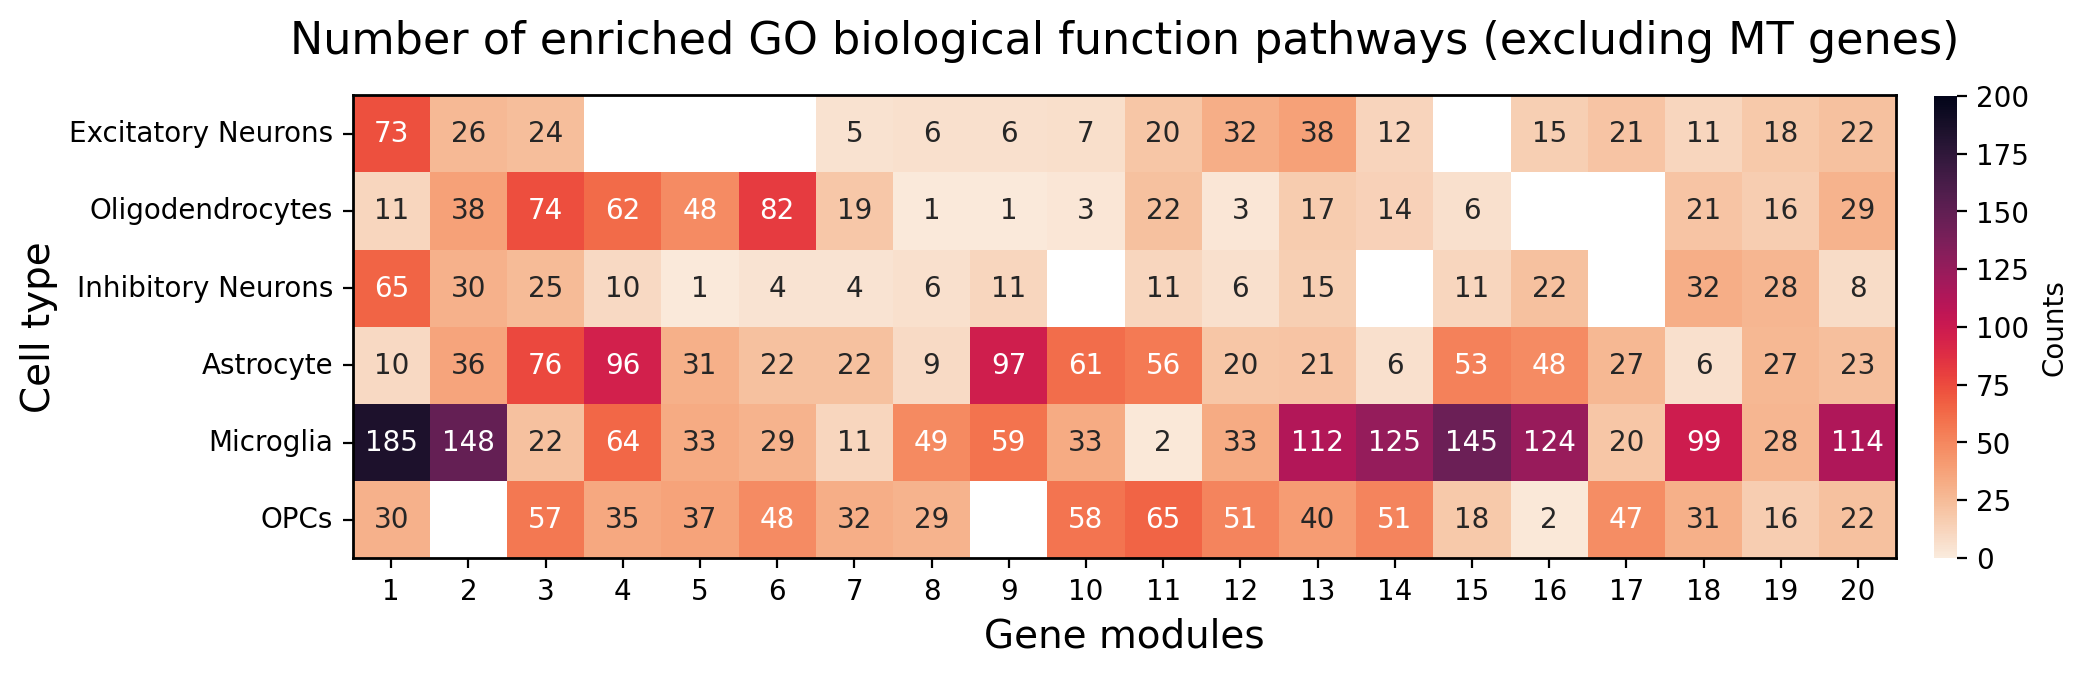

In [32]:
hits_cell_df = pd.read_csv(f'{new_path}/all_hits_raw_counts_no_MT_20_pval_{pval}.csv',index_col=0).loc[cells_order[0:6]]
hits_cell_df['comp_2']['OPCs'] = np.nan
hits_cell_df['comp_16']['Oligodendrocytes'] = np.nan
hits_cell_df['comp_17']['Oligodendrocytes'] = np.nan

figure(figsize=(12,6), dpi=200)
fig = sns.heatmap(hits_cell_df.round(2), cmap = "rocket_r", annot=True, square=True, vmin=0, vmax=200,
             cbar_kws={"shrink": 0.5,"pad":0.02,'label': 'Counts'}, xticklabels=range(1,21),fmt='g')
plt.title('Number of enriched GO biological function pathways (excluding MT genes)', fontsize=16,pad=15)
plt.ylabel('Cell type',fontsize=14)
plt.xlabel('Gene modules',fontsize=14)
fig.spines[:].set_visible(True)
for spine in fig.spines.values():
    spine.set_linewidth(1) 
plt.savefig(f'{date}/updated_plots/enriched_paths_counts_no_MT_pval_{pval}.png', dpi=200, bbox_inches='tight')
plt.show()

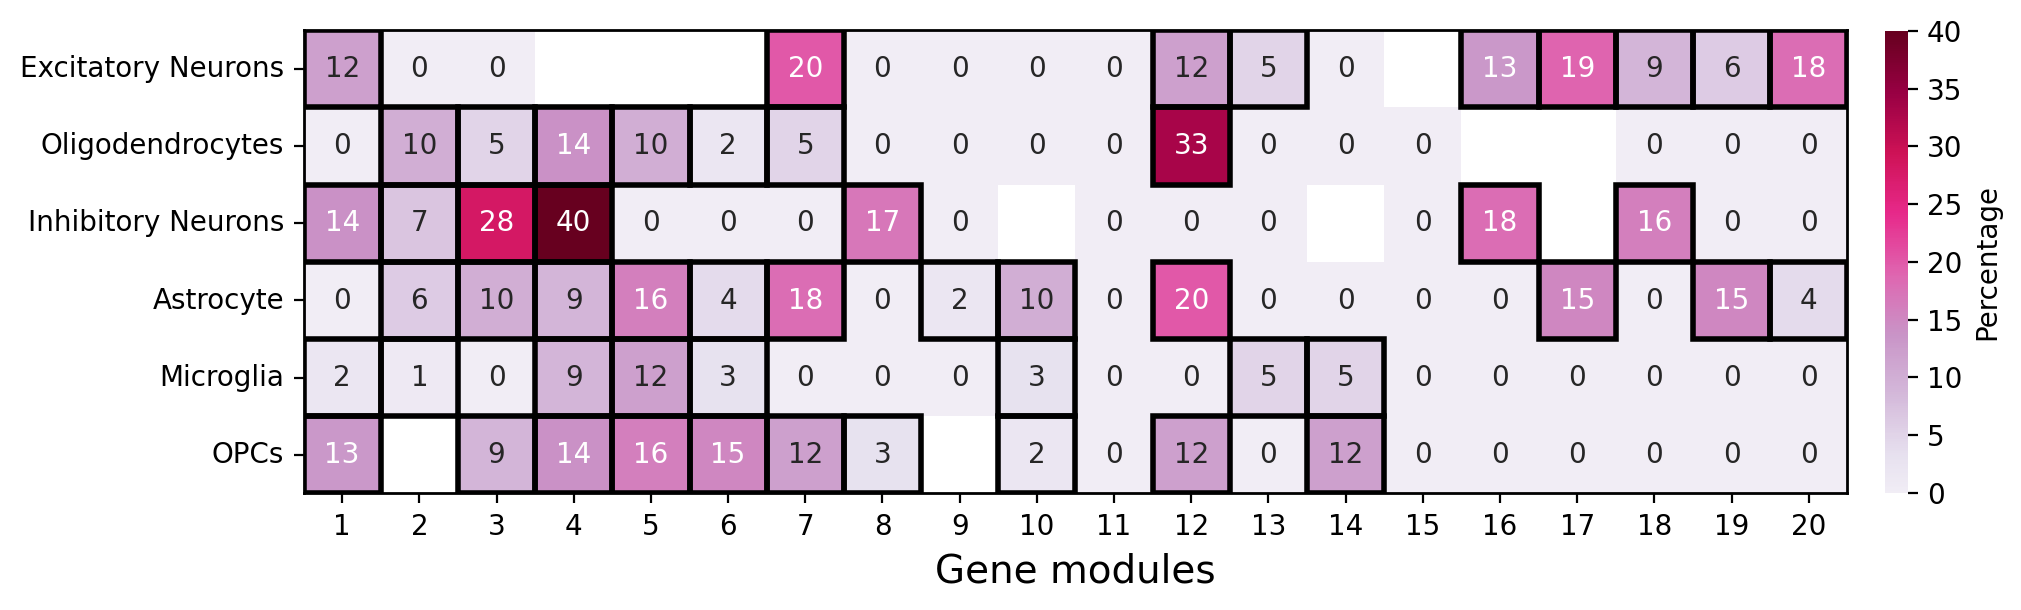

In [33]:
mito_hits_cell_df = pd.DataFrame()
pval = 0.05
for cell_type in cells_order[0:6]:

    paths_df = pd.read_csv(f'{new_path}/{cell_type}_hits_no_MT_20_pval_{pval}_.csv',index_col=0)
    mito_hits_df = pd.DataFrame()

    # Count number of enriched pathways per PLS component
    for i in range(1,21):
        row = f'comp_{i}'
        row_sr = paths_df.loc[row].dropna().copy()
        mito_hit = 0
        N_hits = len(row_sr)
        if N_hits == 0:
            mito_hits_df[row] = np.nan
        else:
            for p in range(0,N_hits):
                s = row_sr.iloc[p]
                if ('Mitoch' in s)|('mitoch' in s):
                    # print('hit')
                    mito_hit += 1
            mito_hits_df[row] = [np.round(mito_hit/N_hits,3)]
    mito_hits_df.index = [cell_type]
    mito_hits_cell_df = pd.concat([mito_hits_cell_df,mito_hits_df],axis=0)   
mito_hits_cell_df.to_csv(f'{new_path}/mito_hits_no_MT_20_pval_{pval}_.csv')

# Define the colormap name
colormap_name = 'PuRd'
# Get the colormap object
cmap = plt.get_cmap(colormap_name)
# Define the range of colors to keep
num_colors = 100
start_index = 0
end_index = num_colors // 2
# Create a truncated colormap
new_cmap = mcolors.LinearSegmentedColormap.from_list('truncated_' + colormap_name, cmap(np.linspace(0, 1, num_colors))[5:100])

hits_cell_df = pd.read_csv(f'{new_path}/mito_hits_no_MT_20_pval_{pval}_.csv',index_col=0).loc[cells_order[0:6]]
hits_cell_df['comp_2']['OPCs'] = np.nan
hits_cell_df['comp_16']['Oligodendrocytes'] = np.nan
hits_cell_df['comp_17']['Oligodendrocytes'] = np.nan

outline_mask = hits_cell_df > 0
fig, ax = plt.subplots(figsize=(12,6), dpi=200)
sns.heatmap(hits_cell_df.round(2)*100, cmap = new_cmap, zorder=1, annot=True, vmin=0, vmax=40, xticklabels=range(1,21), fmt='g', 
            square=True, cbar_kws={"shrink": 0.5, "pad":0.02,"label":'Percentage'})

# Add rectangles around cells with values > 0
for i in range(hits_cell_df.shape[0]):  # Iterate over rows
    for j in range(hits_cell_df.shape[1]):  # Iterate over columns
        if hits_cell_df.iloc[i, j] > 0:
            ax.add_patch(patches.Rectangle((j, i), 1, 1, edgecolor='black', fill=False, lw=2, zorder=3))
ax.spines[:].set_visible(True)
for spine in ax.spines.values():
    spine.set_linewidth(1) 

plt.xlabel('Gene modules',fontsize=14)
plt.savefig(f'{date}/updated_plots/enriched_mt_paths_perc_no_MT_pval_{pval}.png', dpi=200, bbox_inches='tight')
plt.show()

In [34]:
pval = 0.05
one_df = pd.DataFrame()

for cell_type in pls_cells[0:6]:
    cell_df = pd.DataFrame()
    
    # mask non-robust component 
    for comp in range(0,20):

        if ((cell_type == 'OPCs')&(comp==1)):
            continue
        elif ((cell_type == 'Oligodendrocytes')&(comp==15)):
            continue
        elif ((cell_type == 'Oligodendrocytes')&(comp==16)):
            continue
        else:
            # Store the Normalized Enriched Score (NES) of significantly enriched pathways 
            nz_gsea_df_sig = pd.read_csv(f'{new_path}/{cell_type}_comp_{comp+1}_pval_{pval}_hits.csv', index_col=0)
            nz_gsea_df_sig['abs_NES'] = abs(nz_gsea_df_sig.NES)
            nz_gsea_df_sig['comp'] = f'comp_{comp+1}'
            subset_df = nz_gsea_df_sig.sort_values(by='abs_NES', ascending=False).reset_index(drop=True)
            subset_df['iddx'] = comp + 1
            subset_df = subset_df.set_index('iddx')
            cell_df = pd.concat([cell_df, subset_df])

    # Format as a dataframe 
    terms_df = pd.DataFrame(cell_df[['Term','NES']])
    terms_df.index = f'{cell_type}_' + terms_df.index.astype(str)
    terms_df = terms_df.reset_index().reset_index()
    terms_df = terms_df.pivot_table(index='Term', columns='iddx', values='NES', aggfunc='first')
    terms_df = pd.DataFrame((terms_df.fillna(0)/terms_df).sum(axis=1),columns=[cell_type])
    # Merge with other cell types
    one_df = pd.concat([one_df,terms_df],axis=1)
    
# Sort by most prevalent pathways
one_df['Total'] = one_df.sum(axis=1)
top_df = one_df.sort_values(by='Total',ascending=False)
top_phrases = []
for phrase in top_df.index:
    top_phrases.append(phrase.split('(GO:')[0])
top_df.index = top_phrases
phrase_counts = dict(zip(top_df.index, top_df['Total']))
    
print(max(phrase_counts.values()))

83.0


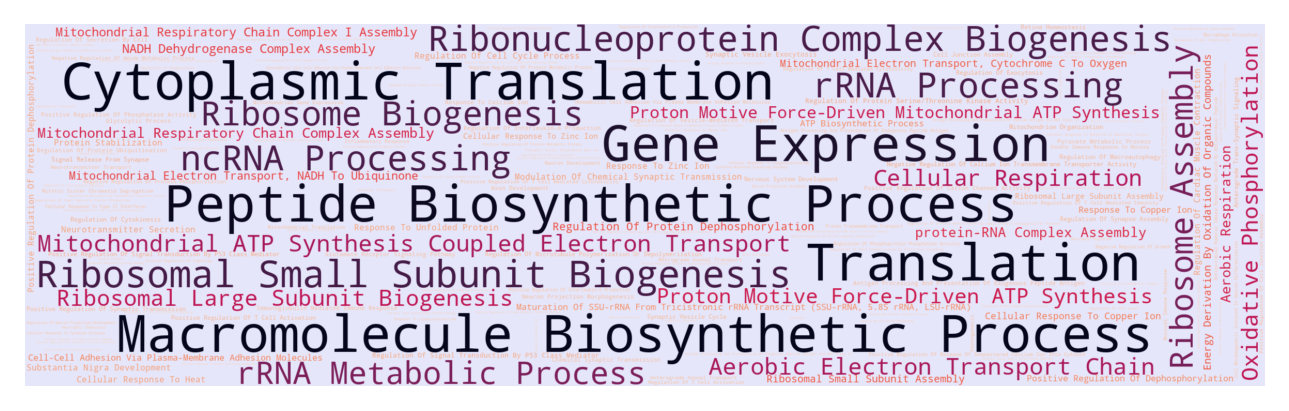

In [35]:
# Create a color function that uses the colormap
def frequency_based_color(word, font_size, position, orientation, random_state=None, **kwargs):
    # Normalize the frequency based on the maximum frequency
    normalized_freq = phrase_counts[word] / max(phrase_counts.values())
    # Get color from the colormap
    color = plt.colormaps.get_cmap('rocket_r')(normalized_freq)
    # Return an RGB tuple
    return (int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))

# Generate the word cloud
wc = WordCloud(
    background_color='lavender',
    width=2400,
    height=700,
    max_font_size=100,
    color_func=frequency_based_color,
    random_state=1,
    contour_color='black',  # Outline color for the shape
).generate_from_frequencies(phrase_counts)

# Display the word cloud
plt.figure(dpi=250)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.savefig(f'{date}/updated_plots/wc_gsea.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()
plt.close('all')

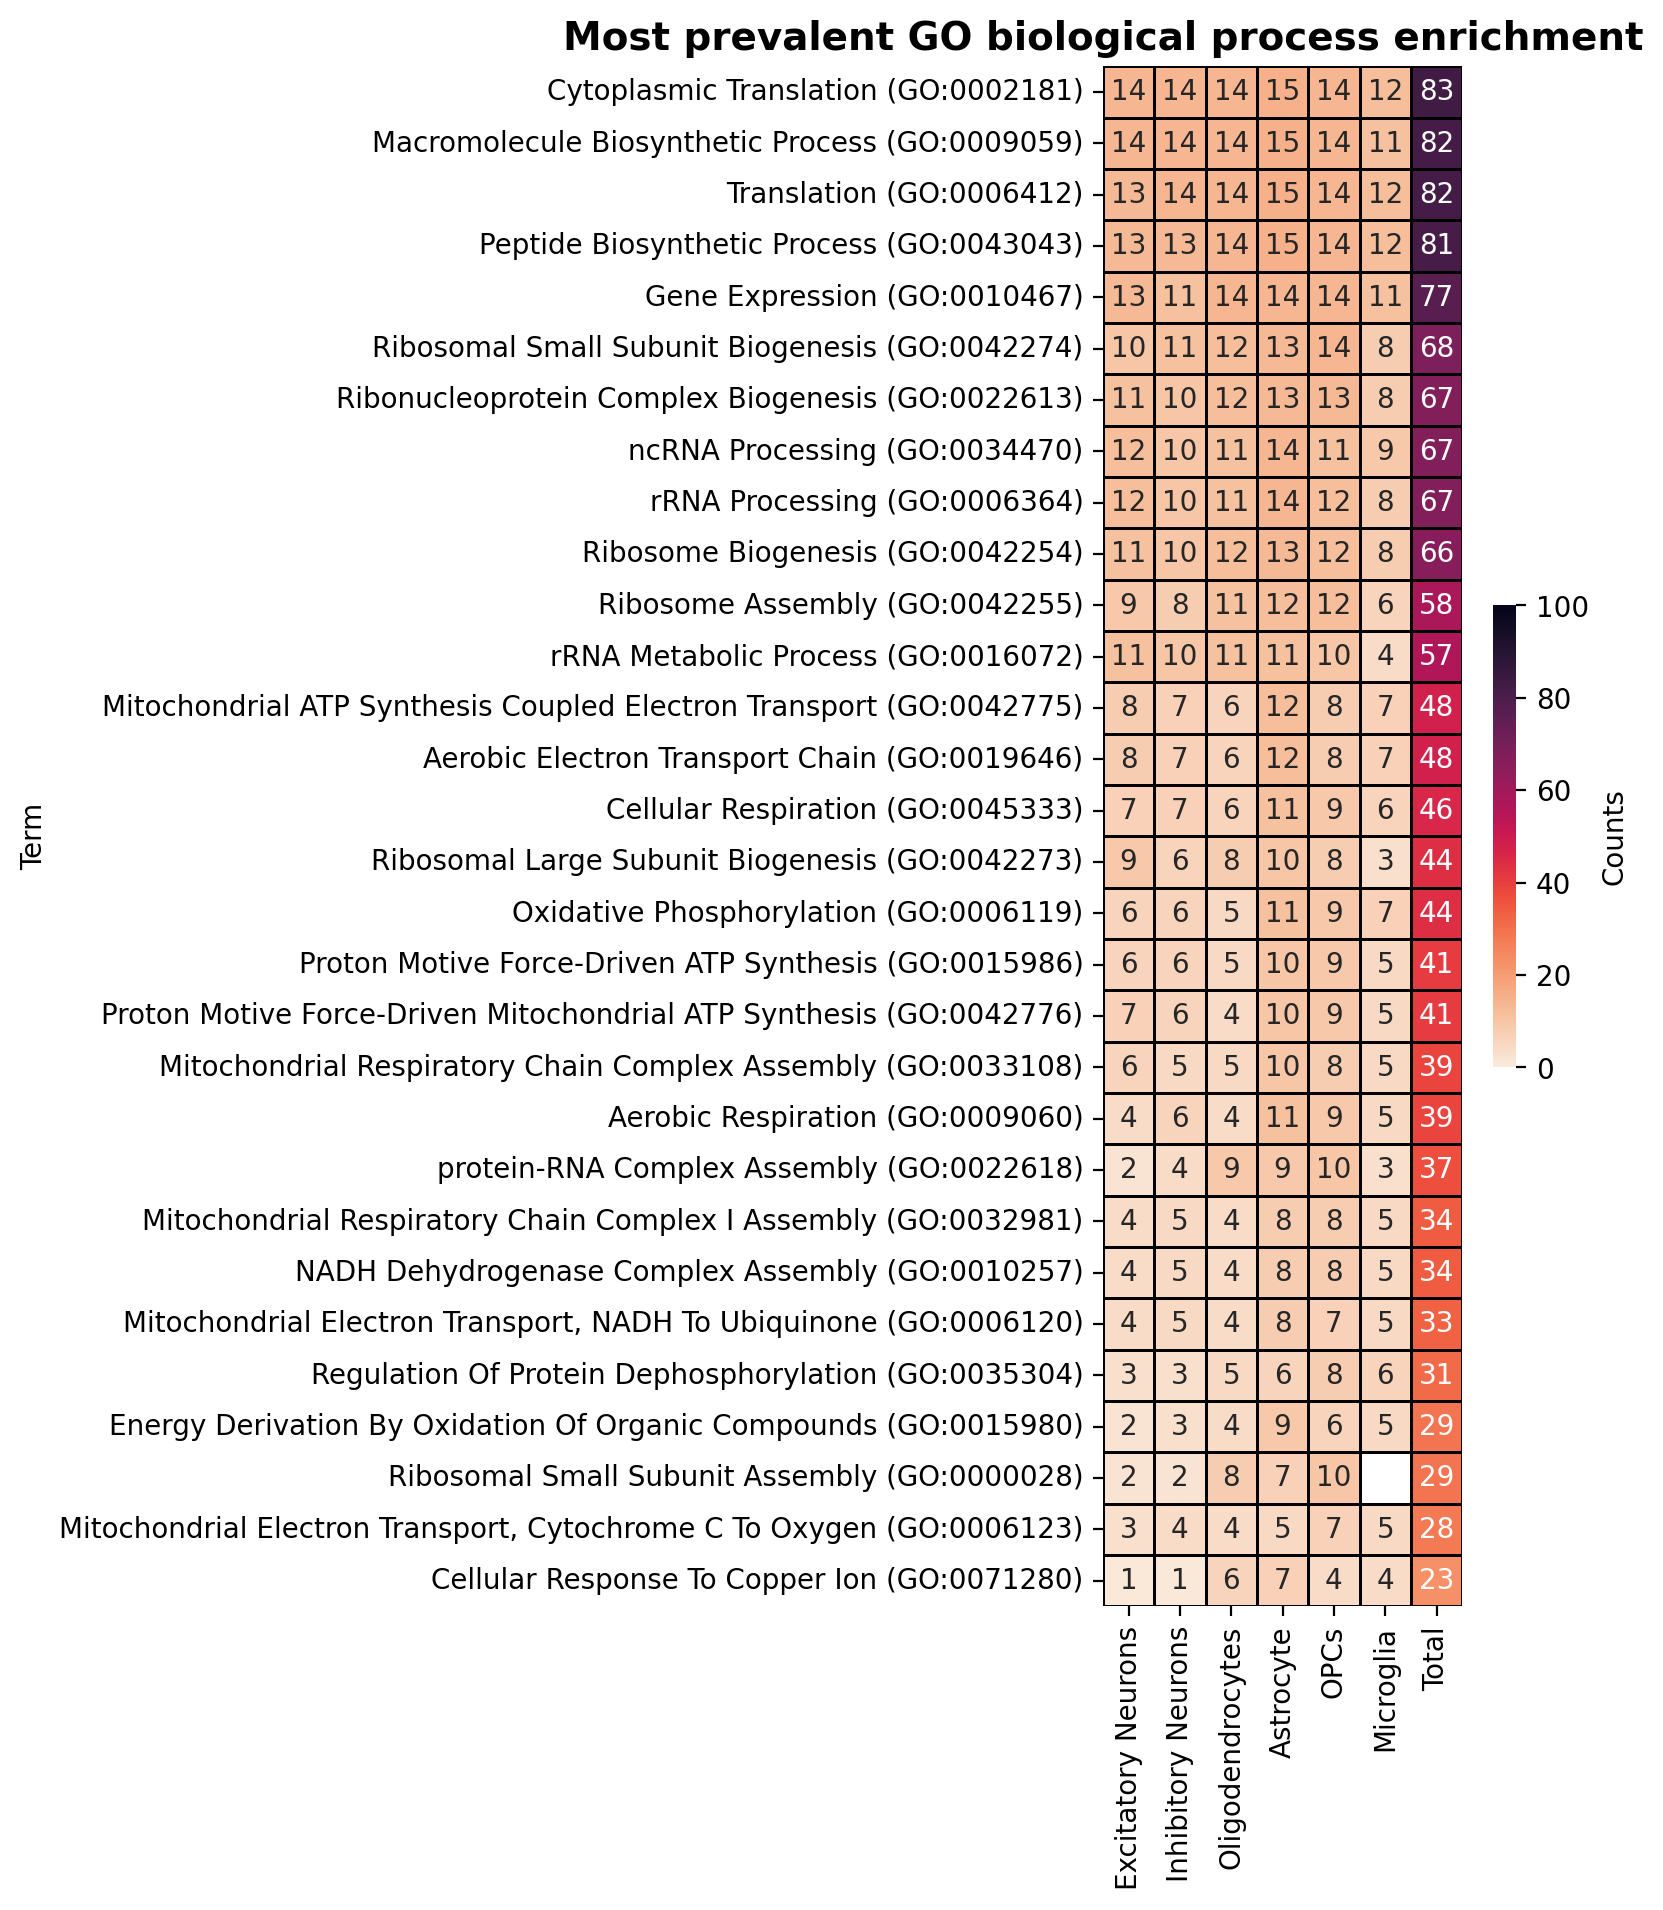

In [36]:
one_df.sort_values(by='Total',ascending=False).head(30).index
plt.figure(figsize=(10,10), dpi=200)
sns.heatmap(one_df.sort_values(by='Total',ascending=False).head(30), annot=True, square=True, cmap = "rocket_r", vmin=0, 
            linewidth=.5, linecolor='black', edgecolor='black', vmax=100,
            cbar_kws={"shrink": 0.3,"pad":0.02,'label': 'Counts'})
plt.title(f'Most prevalent GO biological process enrichment', x=0, fontweight='bold', fontsize=14)
# plt.savefig(f'plots/wc_top_pathways.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close('all')

#### MitoCarta

In [37]:
new_path = f'{date}/AD_PLS/MitoCarta'
print(new_path)

08.13.25/AD_PLS/MitoCarta


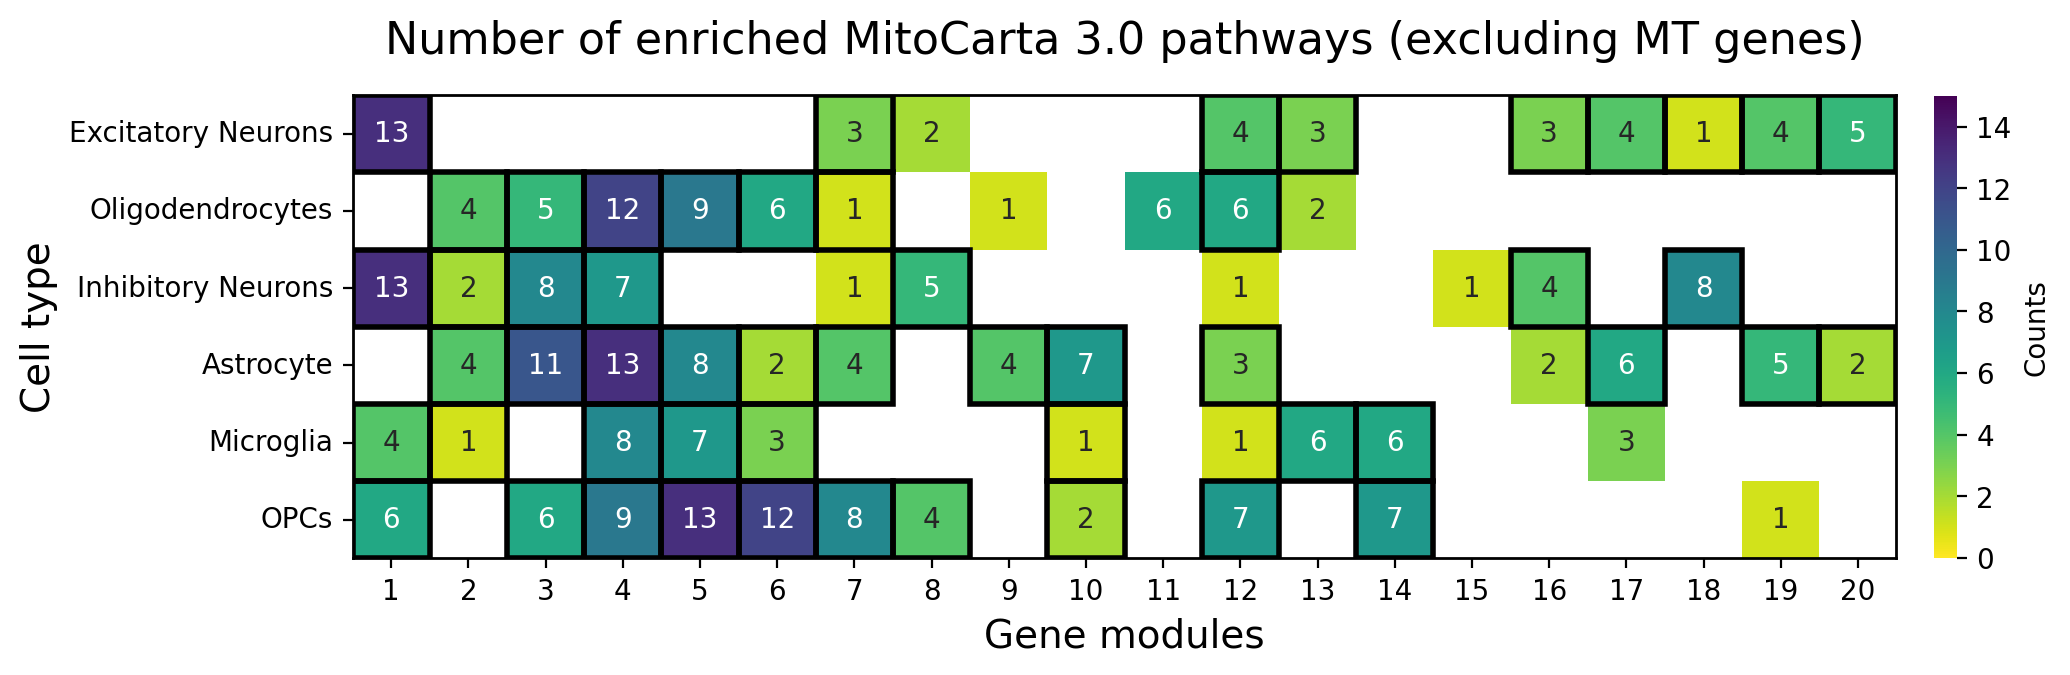

In [38]:
pval = 0.05
mito_hits_cell_df = pd.DataFrame()
for cell_type in cells_order[0:6]:

    paths_df = pd.read_csv(f'{new_path}/{cell_type}_hits_no_MT_20_pval_{pval}.csv',index_col=0)
    mito_hits_df = pd.DataFrame()

    for i in range(1,21):
        row = f'comp_{i}'
        row_sr = paths_df.loc[row].dropna().copy()
        N_hits = len(row_sr)
        if N_hits == 0:
            mito_hits_df[row] = [np.nan]
        else:
            mito_hits_df[row] = [N_hits]
    mito_hits_df.index = [cell_type]
    mito_hits_cell_df = pd.concat([mito_hits_cell_df,mito_hits_df],axis=0)   
mito_hits_cell_df.to_csv(f'{new_path}/all_hits_raw_counts_no_MT_20_pval_{pval}.csv')

cell_df = pd.read_csv(f'{new_path}/all_hits_raw_counts_no_MT_20_pval_{pval}.csv',index_col=0).loc[cells_order[0:6]]
# Masking non-robust components and excluding them from counts 
cell_df['comp_2']['OPCs'] = np.nan
cell_df['comp_16']['Oligodendrocytes'] = np.nan
cell_df['comp_17']['Oligodendrocytes'] = np.nan

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
sns.heatmap(cell_df.round(2), cmap = "viridis_r", annot=True, square=True, vmin=0, vmax=15,
             cbar_kws={"shrink": 0.5,"pad":0.02,'label': 'Counts'}, xticklabels=range(1,21),fmt='g')

# Add rectangles around cells with values > 0
hits_cell_df = pd.read_csv(f'{date}/AD_PLS/GO_Biological_2023/mito_hits_no_MT_20_pval_{pval}_.csv',index_col=0).loc[cells_order[0:6]]
# Masking non-robust components and excluding them from counts 
hits_cell_df['comp_2']['OPCs'] = np.nan
hits_cell_df['comp_16']['Oligodendrocytes'] = np.nan
hits_cell_df['comp_17']['Oligodendrocytes'] = np.nan

for i in range(hits_cell_df.shape[0]):  # Iterate over rows
    for j in range(hits_cell_df.shape[1]):  # Iterate over columns
        if ((hits_cell_df.iloc[i, j] > 0)&(cell_df.iloc[i, j] > 0)):
            ax.add_patch(patches.Rectangle((j, i), 1, 1, edgecolor='black', fill=False, lw=2, zorder=3))

plt.title('Number of enriched MitoCarta 3.0 pathways (excluding MT genes)', fontsize=16,pad=15)
plt.ylabel('Cell type',fontsize=14)
plt.xlabel('Gene modules',fontsize=14)
ax.spines[:].set_visible(True)
for spine in ax.spines.values():
    spine.set_linewidth(1) 
plt.savefig(f'{date}/updated_plots/mitocarta_enriched_paths_counts_no_MT_pval_{pval}.png', dpi=200, bbox_inches='tight')
plt.show()

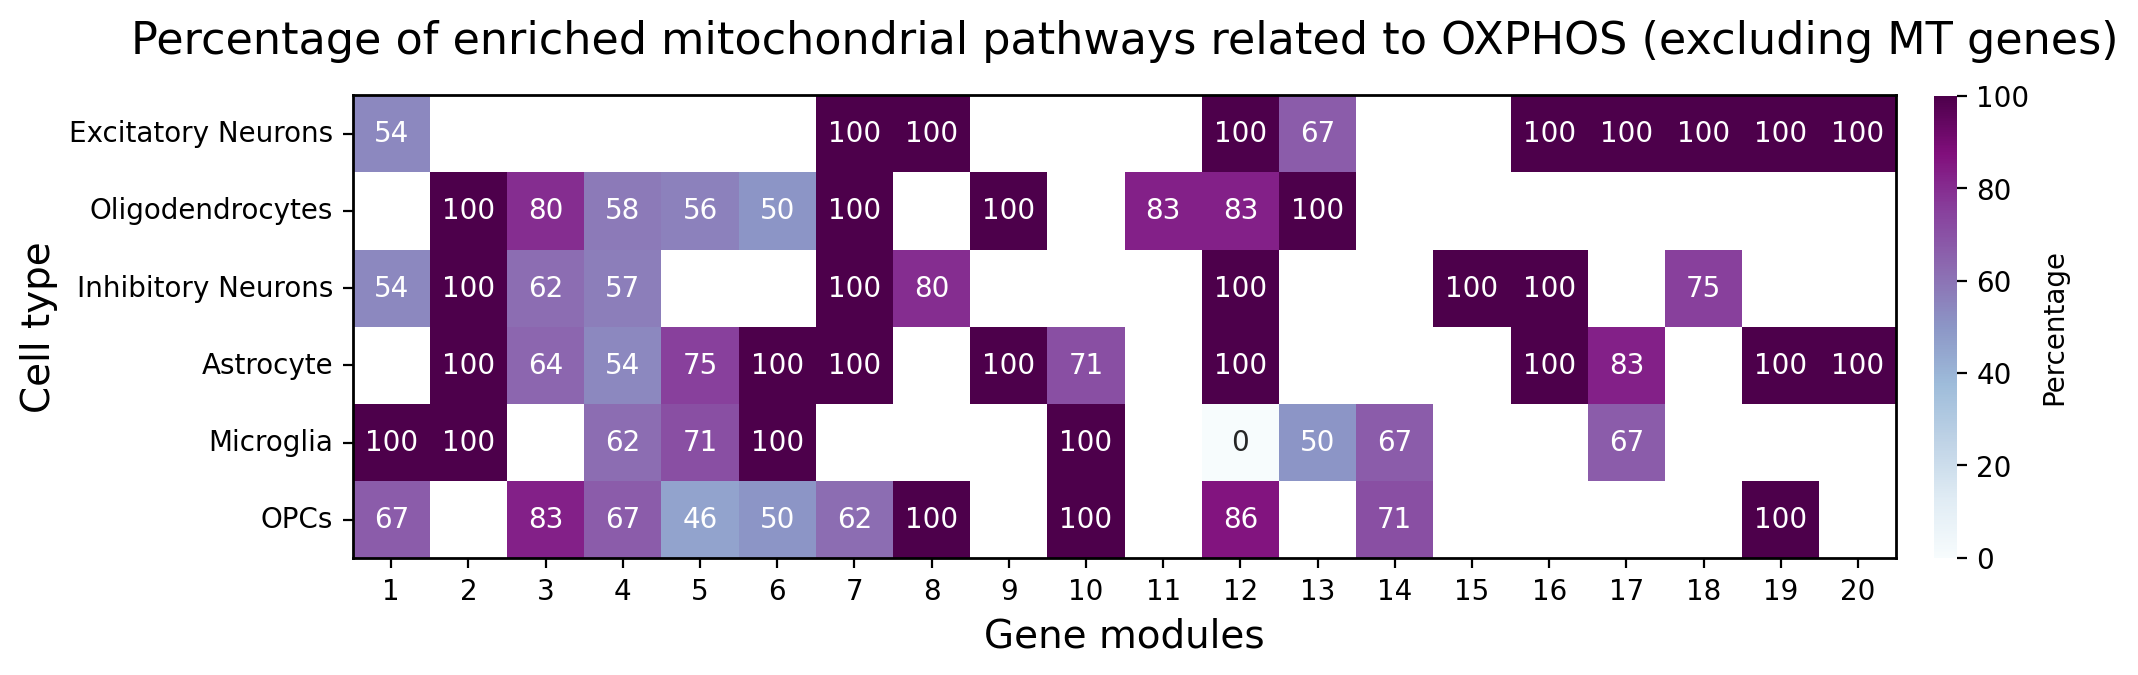

In [39]:
mito_hits_cell_df = pd.DataFrame()
for cell_type in cells_order[0:6]:

    paths_df = pd.read_csv(f'{new_path}/{cell_type}_hits_no_MT_20_pval_{pval}.csv',index_col=0)
    mito_hits_df = pd.DataFrame()

    for i in range(1,21):
        row = f'comp_{i}'
        row_sr = paths_df.loc[row].dropna().copy()
        mito_hit = 0
        N_hits = len(row_sr)
        if N_hits == 0:
            mito_hits_df[row] = np.nan
        else:
            for p in range(0,N_hits):
                s = row_sr.iloc[p]
                if ('OXPHOS' in s):
                    # print('hit')
                    mito_hit += 1
            mito_hits_df[row] = [np.round(mito_hit/N_hits,3)]
    mito_hits_df.index = [cell_type]
    mito_hits_cell_df = pd.concat([mito_hits_cell_df,mito_hits_df],axis=0)   
mito_hits_cell_df.to_csv(f'{new_path}/OXPHOS_hits_no_MT_20_pval_{pval}.csv')

hits_cell_df = pd.read_csv(f'{new_path}/OXPHOS_hits_no_MT_20_pval_{pval}.csv',index_col=0).loc[cells_order[0:6]]
hits_cell_df['comp_2']['OPCs'] = np.nan
hits_cell_df['comp_16']['Oligodendrocytes'] = np.nan
hits_cell_df['comp_17']['Oligodendrocytes'] = np.nan

figure(figsize=(12,6), dpi=200)
fig = sns.heatmap(hits_cell_df.round(2)*100, cmap = 'BuPu', annot=True, vmin=0, vmax=100, xticklabels=range(1,21),
            fmt='g', square=True, cbar_kws={"shrink": 0.5, "pad":0.02,"label":'Percentage'})
plt.title('Percentage of enriched mitochondrial pathways related to OXPHOS (excluding MT genes)', pad=15,fontsize=16)
plt.ylabel('Cell type',fontsize=14)
plt.xlabel('Gene modules',fontsize=14)

fig.spines[:].set_visible(True)
for spine in fig.spines.values():
    spine.set_linewidth(1) 
plt.savefig(f'{date}/updated_plots/enriched_OXPHOS_paths_perc_no_MT_pval_{pval}.png', dpi=200, bbox_inches='tight')
plt.show()


In [40]:
pval = 0.05

one_df = pd.DataFrame()
for cell_type in pls_cells[0:6]:
    cell_df = pd.DataFrame()
    
    for comp in range(0,20):
        # print(rhos)
        nz_gsea_df_sig = pd.read_csv(f'{new_path}/hits_{cell_type}_comp_{comp+1}_pval_{pval}.csv', index_col=0)
        nz_gsea_df_sig['abs_NES'] = abs(nz_gsea_df_sig.NES)
        nz_gsea_df_sig['comp'] = f'comp_{comp+1}'
        subset_df = nz_gsea_df_sig.sort_values(by='abs_NES', ascending=False).reset_index(drop=True)
        subset_df['iddx'] = comp + 1
        subset_df = subset_df.set_index('iddx')
        cell_df = pd.concat([cell_df, subset_df])
    terms_df = pd.DataFrame(cell_df[['Term','NES']])
    terms_df.index = f'{cell_type}_' + terms_df.index.astype(str)
    terms_df = terms_df.reset_index().reset_index()
    terms_df = terms_df.pivot_table(index='Term', columns='iddx', values='NES', aggfunc='first')
    terms_df = pd.DataFrame((terms_df.fillna(0)/terms_df).sum(axis=1),columns=[cell_type])
    one_df = pd.concat([one_df,terms_df],axis=1)

/tmp/ipykernel_308781/158518747.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = cm.get_cmap("viridis_r")(normalized_freq)


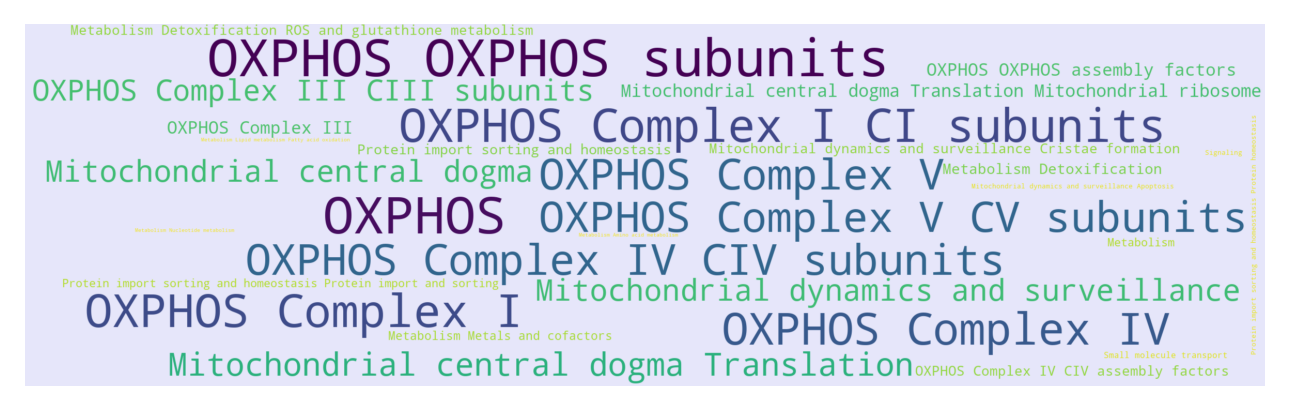

In [41]:
pval = 0.05

one_df = pd.DataFrame()
for cell_type in pls_cells[0:6]:
    cell_df = pd.DataFrame()
    
    for comp in range(0,20):

        # Masking non-robust components and excluding them from counts 
        if ((cell_type == 'OPCs')&(comp==1)):
            continue
        elif ((cell_type == 'Oligodendrocytes')&(comp==15)):
            continue
        elif ((cell_type == 'Oligodendrocytes')&(comp==16)):
            continue
        else:
            nz_gsea_df_sig = pd.read_csv(f'{new_path}/hits_{cell_type}_comp_{comp+1}_pval_{pval}.csv', index_col=0)
            nz_gsea_df_sig['abs_NES'] = abs(nz_gsea_df_sig.NES)
            nz_gsea_df_sig['comp'] = f'comp_{comp+1}'
            subset_df = nz_gsea_df_sig.sort_values(by='abs_NES', ascending=False).reset_index(drop=True)
            subset_df['iddx'] = comp + 1
            subset_df = subset_df.set_index('iddx')
            cell_df = pd.concat([cell_df, subset_df])

    terms_df = pd.DataFrame(cell_df[['Term','NES']])
    terms_df.index = f'{cell_type}_' + terms_df.index.astype(str)
    terms_df = terms_df.reset_index().reset_index()
    terms_df = terms_df.pivot_table(index='Term', columns='iddx', values='NES', aggfunc='first')
    terms_df = pd.DataFrame((terms_df.fillna(0)/terms_df).sum(axis=1),columns=[cell_type])
    one_df = pd.concat([one_df,terms_df],axis=1)

one_df['Total'] = one_df.sum(axis=1)
top_df = one_df.sort_values(by='Total',ascending=False)
top_phrases = []
for phrase in top_df.index:
    pruned_p = phrase.split('(GO:')[0].replace('.',' ').replace('_',' ')
    top_phrases.append(pruned_p)
top_df.index = top_phrases
phrase_counts = dict(zip(top_df.index, top_df['Total']))
    
max(phrase_counts.values())
# Create a color function that uses the colormap
def frequency_based_color(word, font_size, position, orientation, random_state=None, **kwargs):
    # Normalize the frequency based on the maximum frequency
    normalized_freq = phrase_counts[word] / max(phrase_counts.values())
    # Get color from the colormap
    color = cm.get_cmap("viridis_r")(normalized_freq)
    # Return an RGB tuple
    return (int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))

# Generate the word cloud
wc = WordCloud(
    background_color='lavender',
    width=2400,
    height=700,
    max_font_size=100,
    color_func=frequency_based_color,
    random_state=42,
).generate_from_frequencies(phrase_counts)

# Display the word cloud
plt.figure(dpi=250)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.savefig(f'{date}/updated_plots/wc_mito.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()
plt.close('all')

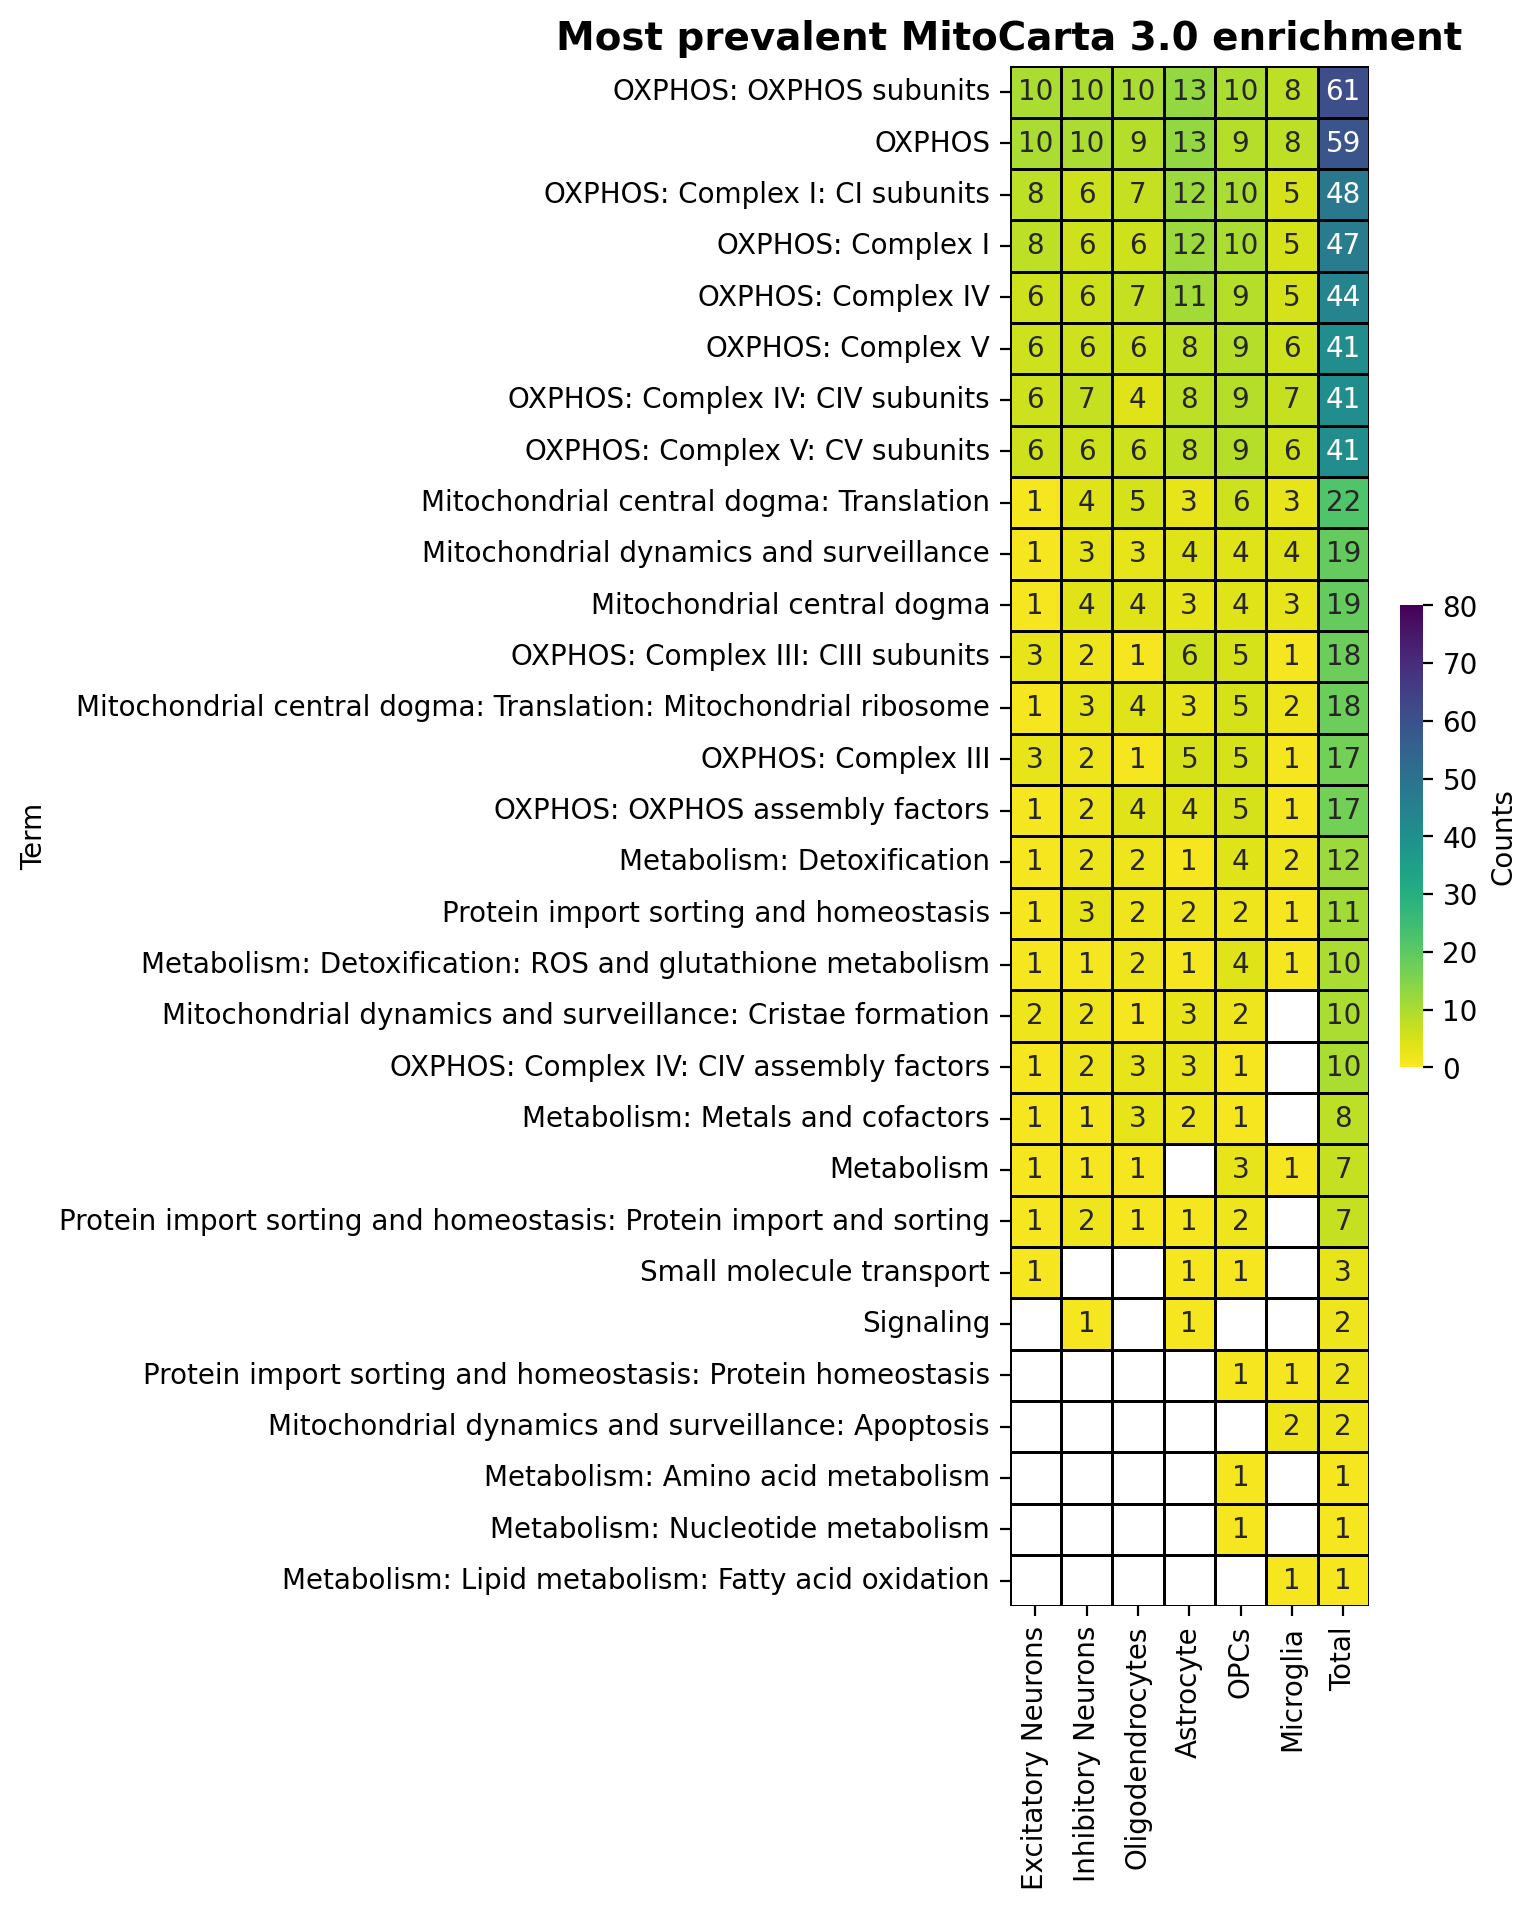

In [42]:
plt.figure(figsize=(10,10), dpi=200)
top_paths = one_df.sort_values(by='Total',ascending=False).head(30)
pruned_p = []
for p in top_paths.index:
    p = p.replace('.',': ').replace('_',' ')
    pruned_p.append(p)
sns.heatmap(one_df.sort_values(by='Total',ascending=False).head(30), annot=True, square=True, 
            cmap = "viridis_r", vmin=0, yticklabels= pruned_p,
            linewidth=.5, linecolor='black', edgecolor='black', vmax=80,
            cbar_kws={"shrink": 0.3,"pad":0.02,'label': 'Counts'})
plt.title(f'Most prevalent MitoCarta 3.0 enrichment', x=0, fontweight='bold', fontsize=14)
plt.savefig(f'plots/top_MitoCarta_pathways_{cell_type}.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close('all')